In [1]:
import torch
print("Torch version:", torch.__version__)
print("GPU Available: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

Torch version: 2.7.0+cpu
GPU Available:  False


In [4]:
import numpy as np

from tensorflow.keras.utils import Sequence

import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math
import random

# define the size for the images to be resized to
img_size = (256, 256)
# define the batch size for the training
batch_size = 10
learning_rate = 1e-4

# The directory holding all of the subdirectories with the dataset
# TODO: set the appropriate path to the images directory

dataset_directory_train = './trainset/'
dataset_directory_val = './validationset/'
dataset_directory_test = './testset/'

# The directory to save the model weights
weights_save_location = 'C:/Users/nagas/Documents/673_new/weights/'

In [6]:
def categorical_encoding_to_prob(img, num_of_classes):
    res_img = np.zeros((img.shape[0], img.shape[1], num_of_classes))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if len(img.shape) == 2:
                index = img[i][j]
            else:
                index = img[i][j][0]
            res_img[i][j][index] = 1

    return res_img

In [8]:
def rgb_to_categorical(img, colors):
    res_img = np.zeros((img.shape[0],img.shape[1]), dtype=int)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tuple(img[i][j]) in colors:
                res_img[i][j] = colors.index(tuple(img[i][j]))
            else:
                res_img[i][j] = 0
    
    return res_img

In [10]:
class DirectoryFlow(Sequence):
    """ Class used to read images from directory in chunks.
    
    This one should allow us to read all of the images from the directories in 
    chunks. Provided directories are ones where original images and their
    corresponding labels reside.  
    For now no augmentations are applied to the elements.
    """
    def __init__(self, x_dir_path, y_dir_path, batch_size, img_size, img_ext='.jpg', label_suffix_ext='_lab.png', skip_encoding=False, is_rgb=False, colors=None):
        """ Creates a list of filenames for latter use. 
        
        Since some of the pictures or maps might have no counterparts in the 
        other directory we should leave only those that do in the list.
        The list contains names  without suffixes and extensions
        """
        self.x_dir_path = x_dir_path
        self.y_dir_path = y_dir_path

        x_list = os.listdir(x_dir_path)
        y_list = os.listdir(y_dir_path)

        self.data_names_list = [x_el.split('.')[0] for x_el in x_list if x_el.split('.')[0]+label_suffix_ext]
        self.temp_data_names = self.data_names_list.copy()
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_ext = img_ext
        self.label_suffix_ext = label_suffix_ext
        self.skip_encoding = skip_encoding
        self.is_rgb = is_rgb
        self.colors = colors

    def _get_image_batch(self, allow_duplicates=False):
        """ Polls temp_data_names for random elements, returns corresponding images.

        Elements are polled using np.random.choice() and are removed on use.
        Then, images and their respective masks are read with a help of the cv2.imread
        and the colors are changed properly from BGR to RGB.
        After that we resize the image and normalize it before feeding into the network

        returns: list of image arrays
        """
        images = []
        labels = []
        if allow_duplicates:
            image_names_list = np.random.choice(self.temp_data_names, (self.batch_size))
        else:
            image_names_list = random.sample(self.temp_data_names, (self.batch_size))
            
        self.temp_data_names = [x for x in self.temp_data_names if x not in image_names_list]

        for i_name in image_names_list:
            image = cv2.imread(self.x_dir_path + '/' + i_name + self.img_ext)
            image = cv2.resize(image, self.img_size, interpolation=cv2.INTER_NEAREST)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image*(1./255)
            
            label = cv2.imread(self.y_dir_path + '/' + i_name + self.label_suffix_ext)
            label = cv2.resize(label, self.img_size, interpolation=cv2.INTER_NEAREST)
            if not self.skip_encoding:
                if self.is_rgb:
                    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
                    label = rgb_to_categorical(label, colors)
                label = categorical_encoding_to_prob(label, 11)
            else:
                label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

            images.append(image)
            labels.append(label)

        return (np.array(images), np.array(labels))

    def __len__(self):
        return int(math.floor(len(self.data_names_list)/self.batch_size))


    def __getitem__(self, index):
        """We discard the index as we are polling random samples"""
        return self._get_image_batch()

    def reset_temp_data_names(self):
        """ Fills temp_data_names with the original list stored in the data_names_list.
        
        Might be used as a callback in order to reset the list between different epochs.
        """
        self.temp_data_names = self.data_names_list.copy()
  
    def on_epoch_end(self):
      self.reset_temp_data_names()

In [12]:
class AugDirectoryFlow(DirectoryFlow):
    """ Class used to read images from directory in chunks.
    
    This one should allow us to read any amount of the images from the 
    directories in chunks. Provided directories are ones where original 
    images and their corresponding labels reside.  
    Augmentations available are horizontal and vertical flip, rotation and zoom in.
    Note that rotation is integer that represents degrees and zoom in is float and
    the value provided is not included in the range
    """
    def __init__(self, x_dir_path, y_dir_path, batch_size, img_size, img_ext='.jpg', label_suffix_ext='_lab.png',\
                 h_flip=False, v_flip=False, rotation_deg=0, zoom_in_scale=1.0, skip_encoding=False, is_rgb=False, colors=None):
        """ Creates a list of filenames for latter use. 
        
        Since some of the pictures or maps might have no counterparts in the 
        other directory we should leave only those that do in the list.
        The list contains names  without suffixes and extensions
        """
        super().__init__(x_dir_path, y_dir_path, batch_size, img_size, img_ext, label_suffix_ext, skip_encoding, is_rgb, colors)
        self.h_flip = h_flip
        self.v_flip = v_flip
        self.rotation_deg = rotation_deg
        if(zoom_in_scale<1.0):
            raise ValueError('Zoom_in_scale is expected to be 1.0 or higher')
            zoom_in_scale = 1.0
        self.zoom_in_scale = zoom_in_scale

    def _apply_augmentations(self,data_pairs):
        images, labels = data_pairs
        for i in range(len(images)):
            if(self.v_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],0)
                    labels[i] = cv2.flip(labels[i],0)
            if(self.h_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],1)
                    labels[i] = cv2.flip(labels[i],1)
            if(self.rotation_deg > 0 or self.zoom_in_scale > 1.0):
                degrees = 0
                if(self.rotation_deg > degrees):
                    degrees = np.random.randint(0,self.rotation_deg+1)
                
                scale = 1.0
                if(self.zoom_in_scale > scale):
                    scale = np.random.uniform(1.0,self.zoom_in_scale)
                    
                height, width, _ = images[i].shape
                rotation = cv2.getRotationMatrix2D((height/2, width/2),\
                                                   degrees,scale)
                images[i] = cv2.warpAffine(images[i], rotation, (width, height))
                labels[i] = cv2.warpAffine(labels[i], rotation, (width, height))
        return (images, labels)
            
        
    def __getitem__(self, index):
        """We discard the index as we are polling random samples"""
        data_pairs = super()._get_image_batch()
        data_pairs = self._apply_augmentations(data_pairs)
        self.reset_temp_data_names()
        return data_pairs

    def reset_temp_data_names(self):
        """ Fills temp_data_names with the original list stored in the data_names_list.
        
        Might be used as a callback in order to reset the list between different epochs.
        """
        super().reset_temp_data_names()

    def on_epoch_end(self):
        pass

In [14]:
dataset_classes_names = {'unlabelled':0, 'water':1, 'building-no-damage':2,\
                         'building-medium-damage':3, 'building-major-damage':4,\
                         'building-total-destruction':5,\
                         'vehicle':6, 'road-clear':7, 'road-blocked':8,\
                         'tree':9, 'pool':10}

colors = [(0, 0, 0),         # Background - Black
    (0, 0, 255),       # Water - Blue
    (0, 255, 0),       # Building No Damage - Green
    (255, 255, 0),     # Building Minor Damage - Yellow
    (255, 165, 0),     # Building Major Damage - Orange
    (255, 0, 0),       # Building Total Destruction - Red
    (0, 255, 255),     # Vehicle - Cyan
    (255, 255, 255),   # Road-Clear - White
    (128, 128, 128),   # Road-Blocked - Gray
    (34, 139, 34),     # Tree - Forest Green
    (75, 0, 130)       # Pool - Indigo
         ]

In [16]:
def class_code_to_rgb(image):
    image = image.numpy()
    result_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            px_class = image[i][j]
            result_img[i][j][0] = px_class*20
            result_img[i][j][1] = px_class*20
            result_img[i][j][2] = px_class*20
    return result_img

In [18]:
def class_code_to_rgb_w_colors(image, colors, use_np=False):
    if not use_np:
        image = image.numpy()
    result_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            px_class = image[i][j]
            result_img[i][j][0] = colors[px_class][0]
            result_img[i][j][1] = colors[px_class][1]
            result_img[i][j][2] = colors[px_class][2]
    return result_img

In [20]:
class AugDirectoryFlow(DirectoryFlow):
    """ Class used to read images from directory in chunks.
    
    This one should allow us to read any amount of the images from the 
    directories in chunks. Provided directories are ones where original 
    images and their corresponding labels reside.  
    Augmentations available are horizontal and vertical flip, rotation and zoom in.
    Note that rotation is integer that represents degrees and zoom in is float and
    the value provided is not included in the range
    """
    def __init__(self, x_dir_path, y_dir_path, batch_size, img_size, img_ext='.jpg', label_suffix_ext='_lab.png',\
                 h_flip=False, v_flip=False, rotation_deg=0, zoom_in_scale=1.0, skip_encoding=False, is_rgb=False, colors=None):
        """ Creates a list of filenames for latter use. 
        
        Since some of the pictures or maps might have no counterparts in the 
        other directory we should leave only those that do in the list.
        The list contains names  without suffixes and extensions
        """
        super().__init__(x_dir_path, y_dir_path, batch_size, img_size, img_ext, label_suffix_ext, skip_encoding, is_rgb, colors)
        self.h_flip = h_flip
        self.v_flip = v_flip
        self.rotation_deg = rotation_deg
        if(zoom_in_scale<1.0):
            raise ValueError('Zoom_in_scale is expected to be 1.0 or higher')
            zoom_in_scale = 1.0
        self.zoom_in_scale = zoom_in_scale

    def _apply_augmentations(self,data_pairs):
        images, labels = data_pairs
        for i in range(len(images)):
            if(self.v_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],0)
                    labels[i] = cv2.flip(labels[i],0)
            if(self.h_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],1)
                    labels[i] = cv2.flip(labels[i],1)
            if(self.rotation_deg > 0 or self.zoom_in_scale > 1.0):
                degrees = 0
                if(self.rotation_deg > degrees):
                    degrees = np.random.randint(0,self.rotation_deg+1)
                
                scale = 1.0
                if(self.zoom_in_scale > scale):
                    scale = np.random.uniform(1.0,self.zoom_in_scale)
                    
                height, width, _ = images[i].shape
                rotation = cv2.getRotationMatrix2D((height/2, width/2),\
                                                   degrees,scale)
                images[i] = cv2.warpAffine(images[i], rotation, (width, height))
                labels[i] = cv2.warpAffine(labels[i], rotation, (width, height))
        return (images, labels)
            
        
    def __getitem__(self, index):
        """We discard the index as we are polling random samples"""
        data_pairs = super()._get_image_batch()
        data_pairs = self._apply_augmentations(data_pairs)
        self.reset_temp_data_names()
        return data_pairs

    def reset_temp_data_names(self):
        """ Fills temp_data_names with the original list stored in the data_names_list.
        
        Might be used as a callback in order to reset the list between different epochs.
        """
        super().reset_temp_data_names()

    def on_epoch_end(self):
        pass

In [22]:
flow = DirectoryFlow(dataset_directory_train+'train-org-img', dataset_directory_train+'train-label-img', batch_size, img_size)
images, labels = flow._get_image_batch()


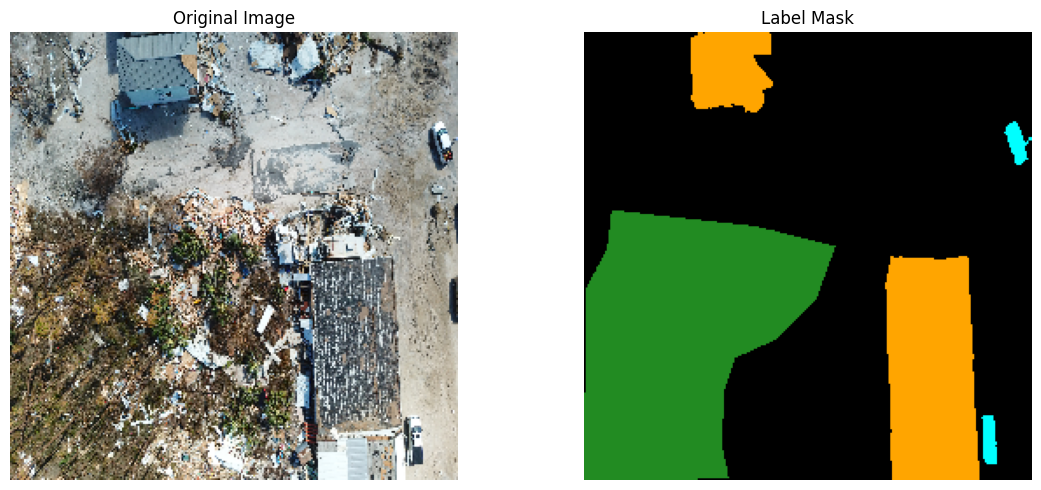

In [24]:
image = images[0]
label = labels[0]

# Convert one-hot encoded labels back to indices
label_indices = np.argmax(label, axis=-1)

# Create RGB image from label indices using the color mapping
height, width = label_indices.shape
label_rgb = np.zeros((height, width, 3), dtype=np.uint8)

# Map each index to its corresponding color
for idx, color in enumerate(colors):
    mask = (label_indices == idx)
    label_rgb[mask] = color

# Display both images side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Label Mask")
plt.imshow(label_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
np.unique(label_indices)

array([0, 4, 6, 9])

In [28]:
label_indices.shape

(256, 256)

In [30]:

print(len(flow.temp_data_names))

3585


In [32]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        
        )
    def forward(self,x):
        return self.conv(x)
    
class encoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.conv = conv_block(in_c,out_c)
        self.pool = nn.MaxPool2d((2,2))
    def forward(self,x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p


class attention_gate(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0],out_c,kernel_size=1,padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1],out_c,kernel_size=1,padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c,out_c,kernel_size=1,padding=0),
            nn.Sigmoid()
        )
    def forward(self,g,s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg+Ws)
        out = self.output(out)
        return out*s
        
class decoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = attention_gate(in_c,out_c)
        self.c1 = conv_block(in_c[0]+out_c,out_c)

    def forward(self,x,s):
        x = self.up(x)
        s = self.ag(x,s)
        x = torch.cat([x,s],axis=1)
        x = self.c1(x)
        return x


class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(3,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)

        self.b1 = conv_block(256,512)
        self.d1 = decoder_block([512,256],256)
        self.d2 = decoder_block([256,128],128)
        self.d3 = decoder_block([128,64],64)
        self.output = nn.Conv2d(64,11,kernel_size=1,padding=0)
    def forward(self,x):
        s1,p1 = self.e1(x)
        s2,p2 = self.e2(p1)
        s3,p3 = self.e3(p2)

        b1 = self.b1(p3)
        #print(b1.shape,s3.shape)
        d1 = self.d1(b1,s3)
        d2 = self.d2(d1,s2)
        d3 = self.d3(d2,s1)
        output = self.output(d3)
        return output
        
x = torch.randn((10,3,256,256))
model = attention_unet()
y = model(x)
print(y.shape)

torch.Size([10, 11, 256, 256])


In [34]:
train_flow = AugDirectoryFlow(dataset_directory_train+'train-org-img',\
                              dataset_directory_train+'train-label-img',\
                              batch_size, img_size, h_flip=True, v_flip=True,\
                              zoom_in_scale=1.3) #rotation_deg=90,
val_flow = DirectoryFlow(dataset_directory_val+'val-org-img',\
                         dataset_directory_val+'val-label-img',\
                         batch_size, img_size)

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize your model
model = attention_unet().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 2
    

Using device: cpu


In [37]:
def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Transpose and convert to tensor
        images = np.transpose(images, (0, 3, 1, 2))  # [B, C, H, W]
        images = torch.tensor(images, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)
        labels = torch.argmax(labels, dim=-1)  # Convert from one-hot encoding to class indices


        # Forward pass
        outputs = model(images)
        
        # Convert labels to the right shape
        labels = labels.squeeze(1)
        
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def validate(model, val_loader, loss_fn):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # Transpose and convert to tensor
            images = np.transpose(images, (0, 3, 1, 2))
            images = torch.tensor(images, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            outputs = model(images)
            labels = labels.squeeze(1)
            
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(val_loader)


In [ ]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_flow, optimizer, loss_fn)
    val_loss = validate(model, val_flow, loss_fn)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    

In [37]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img', dataset_directory_test+'test-label-img', 2, img_size)
(image, label) = test_flow._get_image_batch()

predicted_map = model.predict(image)
#orig picture
plt.imshow(image[0])

predicted_map_val = tf.argmax(predicted_map[0], axis=-1)
plt.imshow(predicted_map_val)

#ground truth
label_val = tf.argmax(label[0], axis=-1)
plt.imshow(label_val)

AttributeError: 'attention_unet' object has no attribute 'predict'

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D,\
                             Dropout, Layer, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow.image as tfimg

import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math
import random
class SkipConnLayer(Layer):
    """ This layer doesn't mutate the data, oly persists previous output.

    The output is stored in the dictionary provided as storage arg and under the
    key provided
    """
    def __init__(self, storage, key):
        """ Storage is a dictionary that holds elements under a specific key.

        Storage should be defined in the same context you intend to use this data 
        later on and key should be easily replicated on a corresponding step.
        """
        super(SkipConnLayer, self).__init__()
        self.storage = storage
        self.key = key

    def call(self, inputs):
        self.storage[0][self.key] = tf.identity(inputs)
        return inputs

In [42]:
class AttentionLayer(Layer):
    """ The data passed to this layer should be concatenated with the corresponding skip data"""
    def __init__(self, storage, key, num_of_filters):
        """ Storage is a dictionary with skip data under a specific key.
        
        Storage should be defined in the same context you added your data in it
        and the key should be present in the context.
        """
        super(AttentionLayer, self).__init__()
        self.storage = storage
        self.key = key
        self.num_of_filters = num_of_filters
        self.prev_layer_conv = Conv2D(num_of_filters, (1,1), activation='relu',\
                                      kernel_initializer='he_normal')
        self.skip_conv = Conv2D(num_of_filters, (1,1), strides=(2,2),\
                                activation='relu', kernel_initializer='he_normal')
        self.post_add_activation = Activation(activation='relu')
        # TODO: check if number of filters here should really be 1 (my guess it should be the same as skip_input.shape[3])
        self.proj_conv = Conv2D(1, (1,1), activation='relu',\
                                kernel_initializer='he_normal')
        self.pre_upsample_activation = Activation(activation='sigmoid')

    def call(self, inputs):
        skip_input = self.storage[0][self.key]
        #print(f'inputs {inputs.shape}')
        #print(f'skips_input {skip_input.shape}')
        inputs_temp = self.prev_layer_conv(inputs)
        skip_temp = self.skip_conv(skip_input)
        temp_features = tf.add(inputs_temp, skip_temp)
        temp_features = self.post_add_activation(temp_features)
        temp_features = self.proj_conv(temp_features)
        temp_features = self.post_add_activation(temp_features)
        temp_features = tfimg.resize(temp_features, (skip_input.shape[1],\
                                                     skip_input.shape[2]),\
                                     method='bilinear')
        return tf.math.multiply(skip_input, temp_features)

In [44]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [46]:
skip_conn_data = np.array([{}])

In [48]:
class UNetSegmentModelOld:
    """ UNet-like model for semantic segmentation.

    Encoder-Decoder type model with convolution and deconvolution (upsampling)
    passes and skip connections.
    """

    def create_model(self, filter_number_list, initial_shape):
        input = Input(initial_shape)
        x = input
        for num_of_filters in filter_number_list[:-1]:
            x = Conv2D(num_of_filters, (3,3), padding='same',\
                       activation='relu', kernel_initializer='he_normal')(x)
            x = Dropout(0.05)(x)
            # The ouput of this layer should be later concatenated to the input
            # of corresponding one in decoder
            x = Conv2D(num_of_filters, (3,3), padding='same',\
                             activation='relu', kernel_initializer='he_normal')(x)
            x = SkipConnLayer(skip_conn_data, f'data_{num_of_filters}')(x)
            x = MaxPooling2D((2,2))(x)

        # The lowermost layers, after this we'll do the deconv and concatenation.
        x = Conv2D(filter_number_list[-1], (3,3), padding='same',\
                   activation='relu', kernel_initializer='he_normal')(x)
        x = Dropout(0.05)(x)
        x = Conv2D(filter_number_list[-1], (3,3), padding='same',\
                   activation='relu', kernel_initializer='he_normal')(x)
        
        for num_of_filters in reversed(filter_number_list[:-1]):
            # Here we concatenate the output from previous layer with 
            # corresponding skip data
            attention_x = AttentionLayer(skip_conn_data,\
                                            f'data_{num_of_filters}', x.shape[3])(x) #skip_conn_data[0][f'data_{num_of_filters}']
            x = Conv2DTranspose(num_of_filters, (2,2), strides=(2,2),\
                                padding='same')(x)
            x = tf.keras.layers.concatenate([attention_x, x], -1)
            x = Conv2D(num_of_filters, (3,3), padding='same',\
                       activation='relu', kernel_initializer='he_normal')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(num_of_filters, (3,3), padding='same',\
                       activation='relu', kernel_initializer='he_normal')(x)

        output = Conv2D(len(dataset_classes_names), (1,1), padding='same',\
                        activation='softmax')(x)
        self.model = Model(inputs=input, outputs=output)
    
    def compile_model(self, base_lr, use_exponential_decay=False, decay_rate=0.0, decay_steps=0):
        """ Compiles the model with a specified optimizer. Returns the model.
        
        Based on use_exponential_decay value either uses ADAM optimizer or SGD with the exponent rate.
        """
        optimizer = None
        if use_exponential_decay:
            learning_rate = ExponentialDecay(base_lr, decay_rate = decay_rate,\
                                             decay_steps = decay_steps)
        else:
            learning_rate = base_lr
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.00001)
            
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy',\
                      metrics = ['accuracy', MyMeanIOU(num_classes=len(dataset_classes_names))])
        return self.model

In [52]:
unetObj = UNetSegmentModelOld()
unetObj.create_model([64, 128, 256, 512], (img_size[1], img_size[0], 3))
model = unetObj.compile_model(learning_rate, True, 0.5, 4000)
train_flow = AugDirectoryFlow(dataset_directory_train+'train-org-img',\
                              dataset_directory_train+'train-label-img',\
                              batch_size, img_size, h_flip=True, v_flip=True,\
                              zoom_in_scale=1.3) #rotation_deg=90,
val_flow = DirectoryFlow(dataset_directory_val+'val-org-img',\
                         dataset_directory_val+'val-label-img',\
                         batch_size, img_size)

if(not os.path.isdir(weights_save_location)):
    os.makedirs(weights_save_location)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_save_location, 'your_model.weights.h5'),
                                                         monitor = 'val_loss',\
                                                         save_best_only=True,\
                                                         save_weights_only=True)


train_steps = len(train_flow)
val_steps = len(val_flow)

In [49]:
if(len(os.listdir(weights_save_location)) != 0):
  model.load_weights(weights_save_location)
  print("Weights loaded successfully!")

ValueError: File format not supported: filepath=C:/Users/nagas/Documents/673_new/weights/. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [54]:
model.fit(train_flow, steps_per_epoch=train_steps, validation_data=val_flow, validation_steps=val_steps, epochs=20, verbose=1)

C:\Users\nagas\Documents\673_new\new_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1673s 5s/step - accuracy: 0.4570 - loss: 1.6925 - my_mean_iou_1: 0.0508 - val_accuracy: 0.5380 - val_loss: 1.3106 - val_my_mean_iou_1: 0.1034
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1656s 5s/step - accuracy: 0.5735 - loss: 1.2511 - my_mean_iou_1: 0.1047 - val_accuracy: 0.6281 - val_loss: 1.1147 - val_my_mean_iou_1: 0.1317
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1666s 5s/step - accuracy: 0.6406 - loss: 1.0901 - my_mean_iou_1: 0.1455 - val_accuracy: 0.6809 - val_loss: 0.9589 - val_my_mean_iou_1: 0.1908
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1654s 5s/step - accuracy: 0.6865 - loss: 0.9821 - my_mean_iou_1: 0.1987 - val_accuracy: 0.6892 - val_loss: 0.9459 - val_my_mean_iou_1: 0.2164
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1654s 5s/step - accuracy: 0.7107 - loss: 0.9223 - my_mean_iou_1: 0.2180 - val_accuracy: 0.6709 - val_loss: 0.9559 - val_my_mean_iou_1: 0.2127
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1653s 5s/step - accuracy: 0.7313 - loss: 0.8566 - 

In [102]:
model.fit(train_flow, steps_per_epoch=train_steps, validation_data=val_flow, validation_steps=val_steps, epochs=20, verbose=1)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1377s 4s/step - accuracy: 0.8088 - loss: 0.5612 - my_mean_iou_1: 0.3660 - val_accuracy: 0.7725 - val_loss: 0.6647 - val_my_mean_iou_1: 0.3457
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1388s 4s/step - accuracy: 0.8151 - loss: 0.5445 - my_mean_iou_1: 0.3706 - val_accuracy: 0.7801 - val_loss: 0.6371 - val_my_mean_iou_1: 0.3488
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1369s 4s/step - accuracy: 0.8245 - loss: 0.5200 - my_mean_iou_1: 0.3852 - val_accuracy: 0.7903 - val_loss: 0.6100 - val_my_mean_iou_1: 0.3584
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1333s 4s/step - accuracy: 0.8238 - loss: 0.5201 - my_mean_iou_1: 0.3827 - val_accuracy: 0.7827 - val_loss: 0.6353 - val_my_mean_iou_1: 0.3638
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1318s 4s/step - accuracy: 0.8267 - loss: 0.5068 - my_mean_iou_1: 0.3917 - val_accuracy: 0.7977 - val_loss: 0.5914 - val_my_mean_iou_1: 0.3710
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1334s 4s/step - accuracy: 0.8229 - loss: 0.5178 - 

In [154]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img', dataset_directory_test+'test-label-img', 2, img_size)
(image, label) = test_flow._get_image_batch()

In [212]:
def get_preprocessed_image_by_name(name_part, image_dir):
    img_size = (256, 256)
    for fname in os.listdir(image_dir):
        if name_part in fname:
            img_path = os.path.join(image_dir, fname)
            image = tf.keras.utils.load_img(img_path, target_size=img_size)
            image = tf.keras.utils.img_to_array(image) / 255.0
            return tf.expand_dims(image, axis=0)  # shape: (1, 256, 256, 3)
    raise FileNotFoundError(f"No image found with name part: {name_part}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


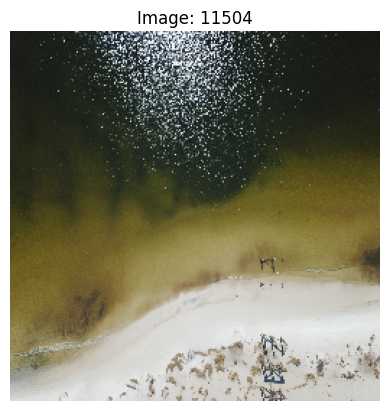

In [230]:
img_name_part = "11504"
image = get_preprocessed_image_by_name(img_name_part, dataset_directory_test + 'test-org-img')

predicted_map = model.predict(image)

# Display original image
plt.imshow(image[0])
plt.title(f"Image: {img_name_part}")
plt.axis('off')
plt.show()


In [232]:
predicted_map = model.predict(img)
#orig picture
plt.imshow(im[0])

ValueError: Unrecognized data type: x=<PIL.MpoImagePlugin.MpoImageFile image mode=RGB size=960x720 at 0x196FBE90B00> (of type <class 'PIL.MpoImagePlugin.MpoImageFile'>)

In [204]:
predicted_map = model.predict(image)
#orig picture
plt.imshow(image[0])

ValueError: Unrecognized data type: x=<PIL.MpoImagePlugin.MpoImageFile image mode=RGB size=960x720 at 0x196FBE90B00> (of type <class 'PIL.MpoImagePlugin.MpoImageFile'>)

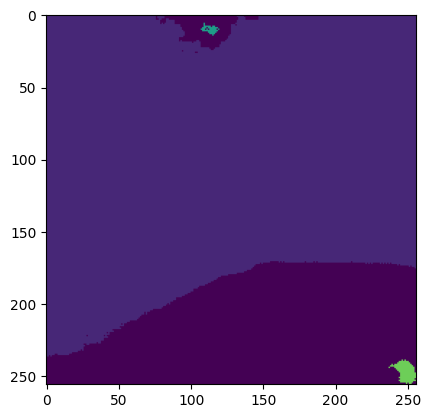

In [234]:
predicted_map_val = tf.argmax(predicted_map[0], axis=-1)
plt.imshow(predicted_map_val)

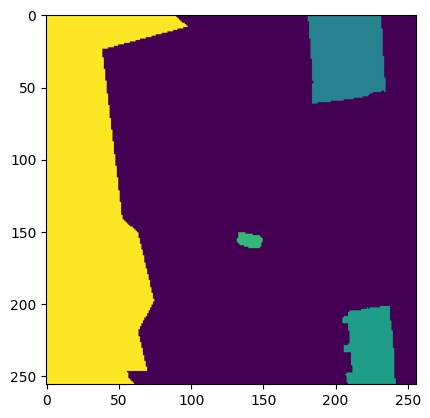

In [218]:
#ground truth
label_val = tf.argmax(label[0], axis=-1)
plt.imshow(label_val)

In [224]:
np.unique(predicted_map_val)

array([0, 1, 2, 3, 4, 6, 7, 9])

In [226]:
np.unique(label_val)

array([0, 4, 5, 6, 9])

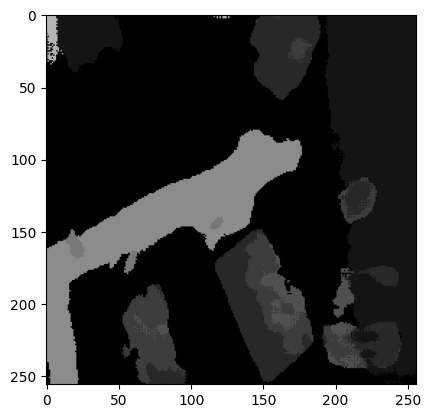

In [228]:
plt.imshow(class_code_to_rgb(predicted_map_val))

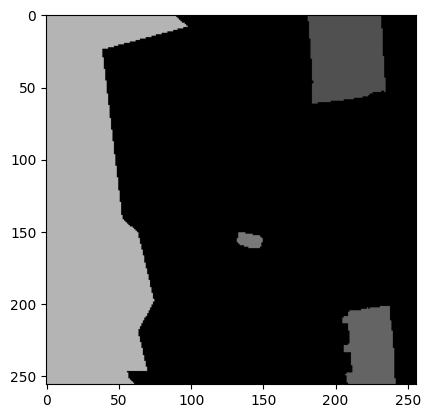

In [222]:
plt.imshow(class_code_to_rgb(label_val))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


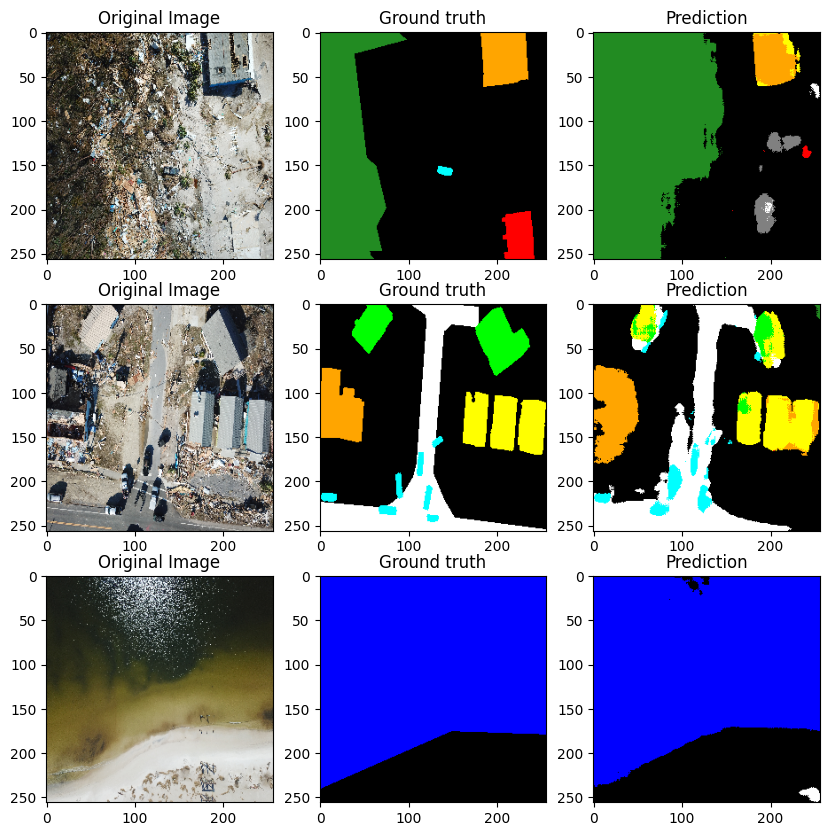

In [174]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img',\
                          dataset_directory_test+'test-label-img', 3, img_size)
(image, label) = test_flow._get_image_batch()
predicted_map = model.predict(image)

fig = plt.figure(figsize=(10,10))

for i in range(3):
    fig.add_subplot(3, 3, i*3+1)
    plt.title("Original Image")
    plt.imshow(image[i])
    
    fig.add_subplot(3, 3, i*3+2)
    plt.title("Ground truth")
    plt.imshow(class_code_to_rgb_w_colors(tf.argmax(label[i], axis=-1), colors))
    
    fig.add_subplot(3, 3, i*3+3)
    plt.title("Prediction")
    plt.imshow(class_code_to_rgb_w_colors(tf.argmax(predicted_map[i], axis=-1), colors))
    
plt.show()

In [132]:
class_names_list = list(dataset_classes_names)
num_of_classes = len(dataset_classes_names)
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img',\
                          dataset_directory_test+'test-label-img', batch_size, img_size)

iou_arr = []
for class_num in range(num_of_classes):
    iou_arr.append(tf.keras.metrics.IoU(num_classes=num_of_classes, target_class_ids=[class_num]))



for _ in range(len(test_flow)):
    (images, labels) = test_flow._get_image_batch()
    predictions = model.predict(images, verbose=0)
    for i in range(len(predictions)):
        prediction = tf.argmax(predictions[i], axis=-1)
        label = tf.argmax(labels[i], axis=-1)
        for class_num in range(num_of_classes):
            class_label = label
            class_pred = prediction
            iou_arr[class_num].update_state(class_label, class_pred)
            


for i, iou in enumerate(iou_arr):
    print(f'Class: {class_names_list[i]}, IoU: {iou.result()}')
test_flow.reset_temp_data_names()

Class: unlabelled, IoU: 0.7081261873245239
Class: water, IoU: 0.7178332805633545
Class: building-no-damage, IoU: 0.39236119389533997
Class: building-medium-damage, IoU: 0.22188183665275574
Class: building-major-damage, IoU: 0.23326395452022552
Class: building-total-destruction, IoU: 0.30870962142944336
Class: vehicle, IoU: 0.24560725688934326
Class: road-clear, IoU: 0.5420494675636292
Class: road-blocked, IoU: 0.030272193253040314
Class: tree, IoU: 0.7170560359954834
Class: pool, IoU: 0.0


In [176]:
from sklearn.metrics import precision_score, recall_score, f1_score
class_names_list = list(dataset_classes_names)
num_of_classes = len(class_names_list)

# Initialize per-class IoU
iou_arr = [tf.keras.metrics.IoU(num_classes=num_of_classes, target_class_ids=[i]) for i in range(num_of_classes)]

# Initialize global trackers
total_pixels = 0
correct_pixels = 0

all_labels = []
all_preds = []
for _ in range(len(test_flow)):
    images, labels = test_flow._get_image_batch()
    predictions = model.predict(images, verbose=0)
    
    for i in range(len(predictions)):
        # One-hot to class index
        pred = tf.argmax(predictions[i], axis=-1).numpy().flatten()
        true = tf.argmax(labels[i], axis=-1).numpy().flatten()

        # For Pixel Accuracy
        correct_pixels += np.sum(pred == true)
        total_pixels += true.size

        # For sklearn metrics
        all_labels.extend(true)
        all_preds.extend(pred)

        # Update IoU metrics
        for class_num in range(num_of_classes):
            iou_arr[class_num].update_state(true, pred)
# Per-class IoU
print("\n--- Per-class IoU ---")
for i, iou in enumerate(iou_arr):
    print(f'Class: {class_names_list[i]:<15} IoU: {iou.result().numpy():.4f}')

# Mean IoU
mean_iou = np.mean([iou.result().numpy() for iou in iou_arr])
print(f"\nMean IoU: {mean_iou:.4f}")

# Pixel Accuracy
pixel_accuracy = correct_pixels / total_pixels
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Precision, Recall, F1 (macro over classes)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")


ValueError: Sample larger than population or is negative

In [82]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 5.6 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.1 MB 8.0 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.1 MB 9.8 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.1 MB 11.2 MB/s eta 0:00:01
   -------------------------------------- - 10.7/11.1 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 10.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.9 MB ? eta -:--:--
   -- ------------------------------------- 2.9/40.9 MB 15.2 MB/s eta 0:00:03
   ------ --------------------------------- 6.6/40.9 MB 16.1 MB/s eta 0:00:03
   -------- ------------------------------- 9.2/40.9 MB 14.6 MB/s eta 0:00:03
   ------------ --------------------------- 12.6/40.9 MB 15.2 MB/s eta 0:00:02
   ----


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: C:\Users\nagas\Documents\673_new\new_env\Scripts\python.exe -m pip install --upgrade pip


In [73]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c):
        super(ConvBlock, self).__init__()
        self.conv = tf.keras.Sequential([
            layers.Conv2D(out_c, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(out_c, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, x):
        return self.conv(x)


class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_c, out_c)
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))

    def call(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p


class AttentionGate(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c):
        super(AttentionGate, self).__init__()

        self.Wg = tf.keras.Sequential([
            layers.Conv2D(out_c, kernel_size=1),
            layers.BatchNormalization()
        ])
        self.Ws = tf.keras.Sequential([
            layers.Conv2D(out_c, kernel_size=1),
            layers.BatchNormalization()
        ])
        self.relu = layers.ReLU()
        self.output_conv = tf.keras.Sequential([
            layers.Conv2D(out_c, kernel_size=1),
            layers.Activation('sigmoid')
        ])

    def call(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output_conv(out)
        return out * s


class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.up = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.ag = AttentionGate(in_c, out_c)
        self.conv = ConvBlock(in_c[0] + out_c, out_c)

    def call(self, x, s):
        x = self.up(x)
        s = self.ag(x, s)
        x = tf.concat([x, s], axis=-1)
        x = self.conv(x)
        return x


class AttentionUNet(Model):
    def __init__(self):
        super(AttentionUNet, self).__init__()
        self.e1 = EncoderBlock(3, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)

        self.b1 = ConvBlock(256, 512)
        self.d1 = DecoderBlock([512, 256], 256)
        self.d2 = DecoderBlock([256, 128], 128)
        self.d3 = DecoderBlock([128, 64], 64)
        self.output_conv = layers.Conv2D(11, kernel_size=1)

    def call(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)

        b1 = self.b1(p3)
        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.output_conv(d3)
        return output


x = tf.random.normal((10, 256, 256, 3))
model1 = AttentionUNet()
y = model1(x)
print(y.shape)


(10, 256, 256, 11)


In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.00001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',\
                      metrics = ['accuracy', MyMeanIOU(num_classes=len(dataset_classes_names))])
	

train_flow = AugDirectoryFlow(dataset_directory_train+'train-org-img',\
                              dataset_directory_train+'train-label-img',\
                              batch_size, img_size, h_flip=True, v_flip=True,\
                              zoom_in_scale=1.3) #rotation_deg=90,
val_flow = DirectoryFlow(dataset_directory_val+'val-org-img',\
                         dataset_directory_val+'val-label-img',\
                         batch_size, img_size)
						 
						 
train_steps = len(train_flow)
val_steps = len(val_flow)
model1.fit(train_flow, steps_per_epoch=train_steps, validation_data=val_flow, validation_steps=val_steps, epochs=10, verbose=1)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2715s 8s/step - accuracy: 0.4412 - loss: nan - my_mean_iou_2: 0.0498 - val_accuracy: 0.5147 - val_loss: nan - val_my_mean_iou_2: 0.0468
Epoch 2/10
253/359 ━━━━━━━━━━━━━━━━━━━━ 12:32 7s/step - accuracy: 0.5306 - loss: nan - my_mean_iou_2: 0.0483


KeyboardInterrupt



In [76]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, out_c, dropout_rate=0.05):
        super(ConvBlock, self).__init__()
        self.conv = tf.keras.Sequential([
            layers.Conv2D(out_c, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
            layers.Dropout(dropout_rate),
            layers.Conv2D(out_c, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
            layers.BatchNormalization(),
        ])

    def call(self, x):
        return self.conv(x)


class AttentionGate(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c):
        super(AttentionGate, self).__init__()
        self.Wg = layers.Conv2D(out_c, kernel_size=1, padding='same')
        self.Wx = layers.Conv2D(out_c, kernel_size=1, padding='same')
        self.psi = layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.relu = layers.ReLU()

    def call(self, g, x):
        g1 = self.Wg(g)
        x1 = self.Wx(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.up = layers.Conv2DTranspose(out_c, kernel_size=2, strides=2, padding='same')
        self.attention = AttentionGate(in_c, out_c)
        self.conv = ConvBlock(out_c)

    def call(self, x, skip):
        x = self.up(x)
        skip = self.attention(x, skip)
        x = tf.concat([x, skip], axis=-1)
        return self.conv(x)


class ImprovedAttentionUNet(Model):
    def __init__(self, num_classes=11, base_filters=64):
        super(ImprovedAttentionUNet, self).__init__()
        self.e1 = ConvBlock(base_filters)
        self.e2 = ConvBlock(base_filters * 2)
        self.e3 = ConvBlock(base_filters * 4)

        self.pool = layers.MaxPooling2D((2, 2))

        self.b1 = ConvBlock(base_filters * 8)

        self.d1 = DecoderBlock(base_filters * 8, base_filters * 4)
        self.d2 = DecoderBlock(base_filters * 4, base_filters * 2)
        self.d3 = DecoderBlock(base_filters * 2, base_filters)

        self.output_conv = layers.Conv2D(num_classes, kernel_size=1, activation='softmax')

    def call(self, x):
        s1 = self.e1(x)
        p1 = self.pool(s1)

        s2 = self.e2(p1)
        p2 = self.pool(s2)

        s3 = self.e3(p2)
        p3 = self.pool(s3)

        b1 = self.b1(p3)

        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.output_conv(d3)
        return output

    def compile_model(self, base_lr, num_classes, use_exponential_decay=False, decay_rate=0.0, decay_steps=0):
        if use_exponential_decay:
            learning_rate = ExponentialDecay(base_lr, decay_steps=decay_steps, decay_rate=decay_rate)
        else:
            learning_rate = base_lr

        optimizer = Adam(learning_rate=learning_rate, weight_decay=0.00001)
        self.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', MyMeanIOU(num_classes=num_classes)])


# Training the model
base_lr = 0.001
num_classes = len(dataset_classes_names)
model = ImprovedAttentionUNet(num_classes=num_classes)
model.compile_model(base_lr=base_lr, num_classes=num_classes)

train_steps = len(train_flow)
val_steps = len(val_flow)

model.fit(train_flow, steps_per_epoch=train_steps, validation_data=val_flow, validation_steps=val_steps, epochs=10, verbose=1)


Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1737s 5s/step - accuracy: 0.5088 - loss: 1.4785 - my_mean_iou_3: 0.0655 - val_accuracy: 0.5977 - val_loss: 1.1219 - val_my_mean_iou_3: 0.1256
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1711s 5s/step - accuracy: 0.5760 - loss: 1.2388 - my_mean_iou_3: 0.1129 - val_accuracy: 0.5748 - val_loss: 1.1490 - val_my_mean_iou_3: 0.1085
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1707s 5s/step - accuracy: 0.6079 - loss: 1.1285 - my_mean_iou_3: 0.1422 - val_accuracy: 0.6110 - val_loss: 1.1078 - val_my_mean_iou_3: 0.1516
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1753s 5s/step - accuracy: 0.6188 - loss: 1.0735 - my_mean_iou_3: 0.1622 - val_accuracy: 0.6190 - val_loss: 1.0494 - val_my_mean_iou_3: 0.1603
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1608s 4s/step - accuracy: 0.6552 - loss: 1.0122 - my_mean_iou_3: 0.1772 - val_accuracy: 0.6542 - val_loss: 0.9948 - val_my_mean_iou_3: 0.1792
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1451s 4s/step - accuracy: 0.6729 - loss: 0.9727 - 

In [116]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img', dataset_directory_test+'test-label-img', 2, img_size)
(image, label) = test_flow._get_image_batch()

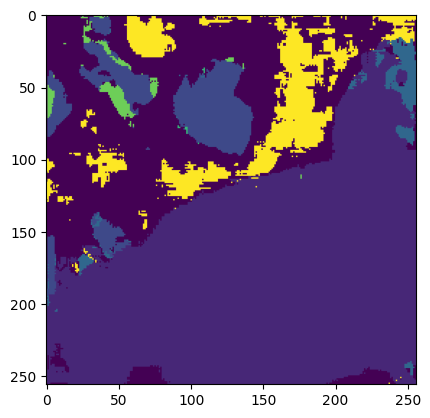

In [118]:
predicted_map_val = tf.argmax(predicted_map[0], axis=-1)
plt.imshow(predicted_map_val)

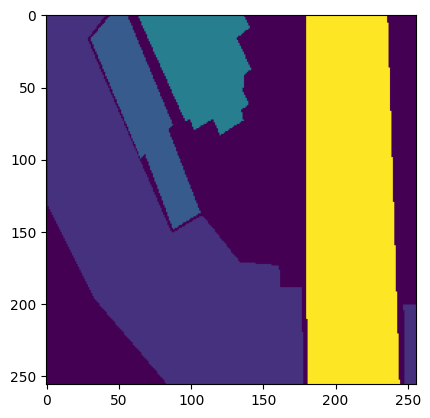

In [120]:
#ground truth
label_val = tf.argmax(label[0], axis=-1)
plt.imshow(label_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


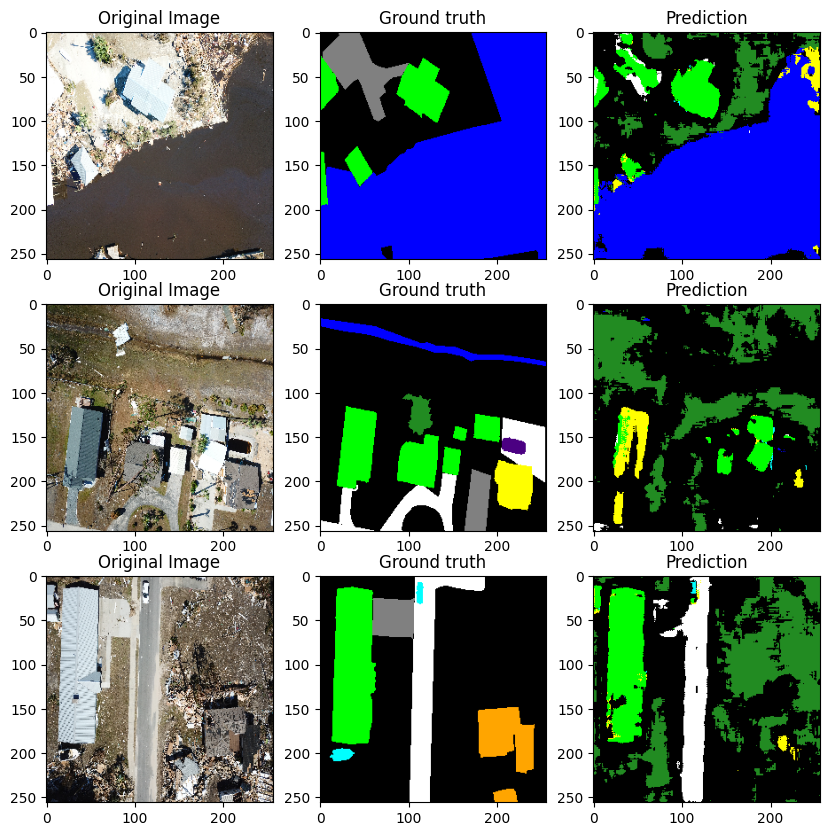

In [88]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img',\
                          dataset_directory_test+'test-label-img', 3, img_size)
(image, label) = test_flow._get_image_batch()
predicted_map = model.predict(image)

fig = plt.figure(figsize=(10,10))

for i in range(3):
    fig.add_subplot(3, 3, i*3+1)
    plt.title("Original Image")
    plt.imshow(image[i])
    
    fig.add_subplot(3, 3, i*3+2)
    plt.title("Ground truth")
    plt.imshow(class_code_to_rgb_w_colors(tf.argmax(label[i], axis=-1), colors))
    
    fig.add_subplot(3, 3, i*3+3)
    plt.title("Prediction")
    plt.imshow(class_code_to_rgb_w_colors(tf.argmax(predicted_map[i], axis=-1), colors))
    
plt.show()

In [86]:
class_names_list = list(dataset_classes_names)
num_of_classes = len(dataset_classes_names)
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img',\
                          dataset_directory_test+'test-label-img', batch_size, img_size)

iou_arr = []
for class_num in range(num_of_classes):
    iou_arr.append(tf.keras.metrics.IoU(num_classes=num_of_classes, target_class_ids=[class_num]))



for _ in range(len(test_flow)):
    (images, labels) = test_flow._get_image_batch()
    predictions = model.predict(images, verbose=0)
    for i in range(len(predictions)):
        prediction = tf.argmax(predictions[i], axis=-1)
        label = tf.argmax(labels[i], axis=-1)
        for class_num in range(num_of_classes):
            class_label = label
            class_pred = prediction
            iou_arr[class_num].update_state(class_label, class_pred)
            


for i, iou in enumerate(iou_arr):
    print(f'Class: {class_names_list[i]}, IoU: {iou.result()}')
test_flow.reset_temp_data_names()

Class: unlabelled, IoU: 0.5626543760299683
Class: water, IoU: 0.6223690509796143
Class: building-no-damage, IoU: 0.2831525206565857
Class: building-medium-damage, IoU: 0.09000403434038162
Class: building-major-damage, IoU: 0.0020596932154148817
Class: building-total-destruction, IoU: 0.00019864775822497904
Class: vehicle, IoU: 0.06010708212852478
Class: road-clear, IoU: 0.2751748263835907
Class: road-blocked, IoU: 0.0
Class: tree, IoU: 0.5679920315742493
Class: pool, IoU: 0.00033288943814113736


In [ ]:
model.fit(train_flow, steps_per_epoch=train_steps, validation_data=val_flow, validation_steps=val_steps, epochs=25, verbose=1)

In [ ]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img', dataset_directory_test+'test-label-img', 2, img_size)
(image, label) = test_flow._get_image_batch()

predicted_map = model.predict(image)
#orig picture
plt.imshow(image[0])

predicted_map_val = tf.argmax(predicted_map[0], axis=-1)
plt.imshow(predicted_map_val)

#ground truth
label_val = tf.argmax(label[0], axis=-1)
plt.imshow(label_val)